Le codage de Huffman est un codage binaire des symboles d'une source d'information qui s'appuie sur les fréquences des symboles. L'idée du codage consiste à coder les symboles les plus fréquents par des mots binaires plus courts que les symboles les moins fréquents. Les codages de Huffman sont *optimaux* dans le sens qu'aucun autre codage binaire des symboles ne permet d'obtenir une source encodée avec moins de bits. 

Le but de ce TP est de réaliser une implantation du codage de Huffman.

1. On commence par calculer le codage binaire optimal permettant de coder une chaîne de caractères en construisant l'arbre de Huffman d'un tel codage
2. Puis une fois construit cet arbre, on en déduit une table de codage
3. On s'intéresse ensuite au décodage d'une chaîne de bits produite par le codage d'une source.
4. Enfin on envisage le cas où la source est un fichier :
   * fichier texte d'abord,
   * fichier quelconque ensuite.

Nous aurons besoin d'utiliser des arbres binaires. On importe donc la classe `BinaryTree` du module `binary_tree`.

In [347]:
from binary_tree import BinaryTree as BT

La fonction suivante pourra être utile pour visualiser des arbres.

In [348]:
import graphviz
from IPython.display import display
def show_tree(arbre):
    display(graphviz.Source(arbre.to_dot()))

# Codage d'une source

Nous allons considérer que les sources à coder sont des chaînes de caractères. Il est très facile d'étendre l'algorithme à d'autres sources, en particulier à des fichiers considérés comme des séquences d'octets (ce qui sera envisagé dans la dernière partie).

Voici un texte qui nous servira d'exemple pour la suite. Cette chaîne de caractères peut bien évidemment être remplacée par toute autre chaîne.

In [349]:
texte_source = '''La Cigale et la Fourmi

La Cigale, ayant chanté
Tout l'été,
Se trouva fort dépourvue
Quand la bise fut venue :
Pas un seul petit morceau
De mouche ou de vermisseau.
Elle alla crier famine
Chez la Fourmi sa voisine,
La priant de lui prêter
Quelque grain pour subsister
Jusqu'à la saison nouvelle.
Je vous paierai, lui dit-elle,
Avant l'Oût, foi d'animal,
Intérêt et principal. 
La Fourmi n'est pas prêteuse :
C'est là son moindre défaut.
Que faisiez-vous au temps chaud ?
Dit-elle à cette emprunteuse.
Nuit et jour à tout venant
Je chantais, ne vous déplaise.
Vous chantiez ? j'en suis fort aise.
Eh bien! dansez maintenant.
''' 

## Nombre d'occurrences des symboles de la source

La première étape consiste à déterminer le nombre d'occurrences de chacun des symboles de la source.

**À faire**
Réalisez la fonction spécifiée ci-dessous, et appliquez la à notre exemple de texte source. 

In [350]:
def sequence_to_occurrences(seq):
    '''
    :param seq: une séquence de symboles 
    :return: (dict) un dictionnaire donnant le nombre 
          d'occurrences de chacun des symboles contenu dans seq
    :CU: les symboles de seq doivent pouvoir être une clé d'un dictionnaire.
    :Exemple:
    
    >>> sequence_to_occurrences('Codage de Huffman') == {'C': 1, 'o': 1, 'd': 2, 'a': 2, 'g': 1, 'e': 2, ' ': 2, 'H': 1, 'u': 1, 'f': 2, 'm': 1, 'n': 1}
    True
    '''
    dico={}
    for elt in seq:
        if elt in dico:
            dico[elt]+=1
        else:
            dico[elt]=1
    return dico
    
    

In [351]:
sequence_to_occurrences('Codage de Huffman') == {'C': 1, 'o': 1, 'd': 2, 'a': 2, 'g': 1, 'e': 2, ' ': 2, 'H': 1, 'u': 1, 'f': 2, 'm': 1, 'n': 1}

True

In [352]:
sequence_to_occurrences('Codage de Huffman') == {'C': 1, 'o': 1, 'd': 2, 'a': 2, 'g': 1, 'e': 2, ' ': 2, 'H': 1, 'u': 1, 'f': 2, 'm': 1, 'n': 1}

True

In [353]:
occ_source = sequence_to_occurrences(texte_source)
print(occ_source)

{'L': 4, 'a': 45, ' ': 86, 'C': 4, 'i': 37, 'g': 3, 'l': 26, 'e': 59, 't': 38, 'F': 3, 'o': 24, 'u': 40, 'r': 24, 'm': 12, '\n': 24, ',': 8, 'y': 1, 'n': 30, 'c': 9, 'h': 7, 'é': 7, 'T': 1, "'": 7, 'S': 1, 'v': 11, 'f': 7, 'd': 11, 'p': 13, 'Q': 3, 'b': 3, 's': 31, ':': 2, 'P': 1, 'D': 2, '.': 8, 'E': 2, 'z': 4, 'ê': 3, 'q': 2, 'J': 3, 'à': 4, '-': 3, 'A': 1, 'O': 1, 'û': 1, 'I': 1, '?': 2, 'N': 1, 'j': 2, 'V': 1, '!': 1}


In [354]:
sequence_to_occurrences('Codage de Huffman') == {'C': 1, 'o': 1, 'd': 2, 'a': 2, 'g': 1, 'e': 2, ' ': 2, 'H': 1, 'u': 1, 'f': 2, 'm': 1, 'n': 1}

True

## Construction de l'arbre de Huffman d'une source

Connaissant les nombres d'occurrences (ou les fréquences) des différents symboles de la source à encoder, il s'agit maintenant de construire l'arbre d'un codage optimal de cette source en suivant l'algorithme de Huffman.

### Un exemple « à la main »

Commençons par une petit exemple traité «à la main», dans lequel le texte source contient cinq fois la lettre `a`, deux fois la lettre `b` et une fois chacune des lettres `c` et `d`.

In [355]:
exple_occ = {'a':5, 'b':2, 'c':1, 'd':1}

Les arbres binaires auront les symboles de la source aux feuilles. Tous les nœuds seront étiquetés par un couple dont 
* la première composante est un symbole de la source pour les feuilles, une chaîne de caractères vide pour les nœuds internes, et 
* la seconde composante est la fréquence du symbole pour les feuilles, la somme des fréquences des symboles situés sous le nœud pour les nœuds internes. 

Voici un exemple d'abre pour la source exemple ci-dessus.

![exemple d'arbre de Huffman](exple_huffman_tree.png)

Nous appellerons *poids d'un arbre* le nombre qui figure dans le couple qui étiquette la racine de l'arbre.

**À faire** Réalisez la fonction suivante qui renvoie le poids d'un arbre.

In [356]:
def weight(tree):
    '''
    :param tree: (BinaryTree) un arbre binaire étiqueté par des couples (truc, nombre)
    :return: (int ou float) le poids de l'arbre, (ie le nombre composante droite du couple étiquette de l'arbre)
     '''
    poids=tree.get_data()
    return poids[1]

In [357]:
VIDE = BT()
arbre= BT(('a', exple_occ['a']), VIDE, VIDE)
weight(arbre)

5

L'algorithme de Huffman construisant l'arbre d'un codage binaire optimal est un exemple d'algorithme glouton qui opère sur une forêt d'arbres en remplaçant les deux arbres dont la racine porte les fréquences les plus petites par un nouvel arbre obtenu en regroupant ces deux arbres en un seul.

On commence avec une forêt constituée d'arbres réduits à une feuille.

In [358]:
VIDE = BT()
foret = [BT(('a', exple_occ['a']), VIDE, VIDE), BT(('b', exple_occ['b']), VIDE, VIDE),
         BT(('c', exple_occ['c']), VIDE, VIDE), BT(('d', exple_occ['d']), VIDE, VIDE)]

**À faire** Réalisez la fonction suivante.

In [359]:
def insert(tree, forest):
    '''
    :param tree: (BinaryTree) un arbre étiqueté par des couples (truc, nombre)
    :param forest: (list) une liste d'arbres binaires étiquetés par des couples (truc, nombre) rangés dans l'ordre décroissant des poids
    :return: (NoneType)
    :side effect: modifie la foret en insérant l'arbre à la première position qui maintient la forêt rangée en ordre décroissant
    '''
    i=0
    while i<len(forest) and weight(forest[i])>weight(tree):
        i+=1        
    forest.insert(i,tree)    
    return 

In [360]:
VIDE = BT()
foret = [BT(('a', exple_occ['a']), VIDE, VIDE), BT(('b', exple_occ['b']), VIDE, VIDE),
         BT(('c', exple_occ['c']), VIDE, VIDE), BT(('d', exple_occ['d']), VIDE, VIDE)]
arbre=BT(('d', exple_occ['d']), VIDE, VIDE)
for t in foret:
    print(t)
print("............")
insert(arbre,foret)
for t in foret:
    print(t)

(('a', 5), (), ())
(('b', 2), (), ())
(('c', 1), (), ())
(('d', 1), (), ())
............
(('a', 5), (), ())
(('b', 2), (), ())
(('d', 1), (), ())
(('c', 1), (), ())
(('d', 1), (), ())


On retire les deux arbres les « moins lourds » de la forêt et on les regroupe en un seul qu'on remet dans la forêt.

In [361]:
arb1 = foret.pop()
arb2 = foret.pop()
insert(BT(('', weight(arb1) + weight(arb2)), arb1, arb2), foret)
for t in foret:
    print(t)

(('a', 5), (), ())
(('', 2), (('d', 1), (), ()), (('c', 1), (), ()))
(('b', 2), (), ())
(('d', 1), (), ())


À ce stade la forêt contient trois arbres rangés dans l'ordre décroissant de leurs poids. Il aurait pu en être autrement.

On réitère les mêmes opérations qu'auparavant pour obtenir une forêt de deux arbres.

In [362]:
arb1 = foret.pop()
arb2 = foret.pop()
insert(BT(('', weight(arb1) + weight(arb2)), arb1, arb2), foret)

Encore une dernière fois pour obtenir une forêt d'un seul arbre.

In [363]:
arb1 = foret.pop()
arb2 = foret.pop()
insert(BT(('', weight(arb1) + weight(arb2)), arb1, arb2), foret)

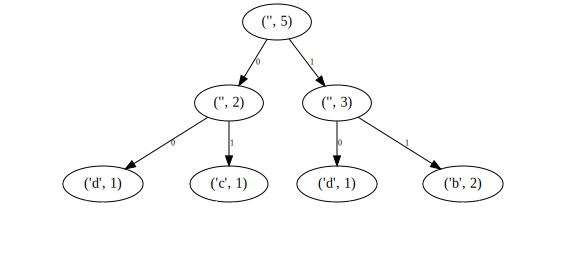

In [364]:
exple_arb_huffman = foret[0]
show_tree(exple_arb_huffman)

**Remarque** Lorsque dans une étape de la construction on réunit deux arbres de la forêt en un seul, savoir lequel de ces deux arbres on place à gauche et lequel on place à droite importe peu. Cela implique qu'il n'y a pas unicité de l'arbre de Huffman (et donc du codage optimal) pour une source donnée. L'emploi de l'article défini dans le titre de cette section est donc impropre.

### Une fonction pour la construction

**À faire** Programmez la fonction suivante qui à partir d'un dictionnaire d'occurrences construit l'arbre d'un codage de Huffman pour une source décrite par le dictionnaire. Appliquez cette fonction à la source définie par notre texte exemple.

Pour s'assurer d'avoir toujours un même arbre pour un même dictionnaire d'occurrences (cf remarque précédente), il est important de trier les clés du dictionnaire avant de le parcourir (`sorted(occ.keys())`).

In [365]:
def huffman_tree(occ):
    '''
    :param occ: (dict) dictionnaires d'occurrences
    :return: (BinaryTree) arbre de codage de Huffman
    '''
    foret=[]
    VIDE =BT()
    print(occ)
    for cle,valeur in occ.items():
        foret.append(BT((cle,valeur),VIDE,VIDE))
    #print(foret)
    
    while len(foret)>1:
        arb1 =foret.pop()
        arb2= foret.pop()
        insert(BT(('', weight(arb1) + weight(arb2)), arb1, arb2), foret)
    
    return foret[0]



{'L': 4, 'a': 45, ' ': 86, 'C': 4, 'i': 37, 'g': 3, 'l': 26, 'e': 59, 't': 38, 'F': 3, 'o': 24, 'u': 40, 'r': 24, 'm': 12, '\n': 24, ',': 8, 'y': 1, 'n': 30, 'c': 9, 'h': 7, 'é': 7, 'T': 1, "'": 7, 'S': 1, 'v': 11, 'f': 7, 'd': 11, 'p': 13, 'Q': 3, 'b': 3, 's': 31, ':': 2, 'P': 1, 'D': 2, '.': 8, 'E': 2, 'z': 4, 'ê': 3, 'q': 2, 'J': 3, 'à': 4, '-': 3, 'A': 1, 'O': 1, 'û': 1, 'I': 1, '?': 2, 'N': 1, 'j': 2, 'V': 1, '!': 1}


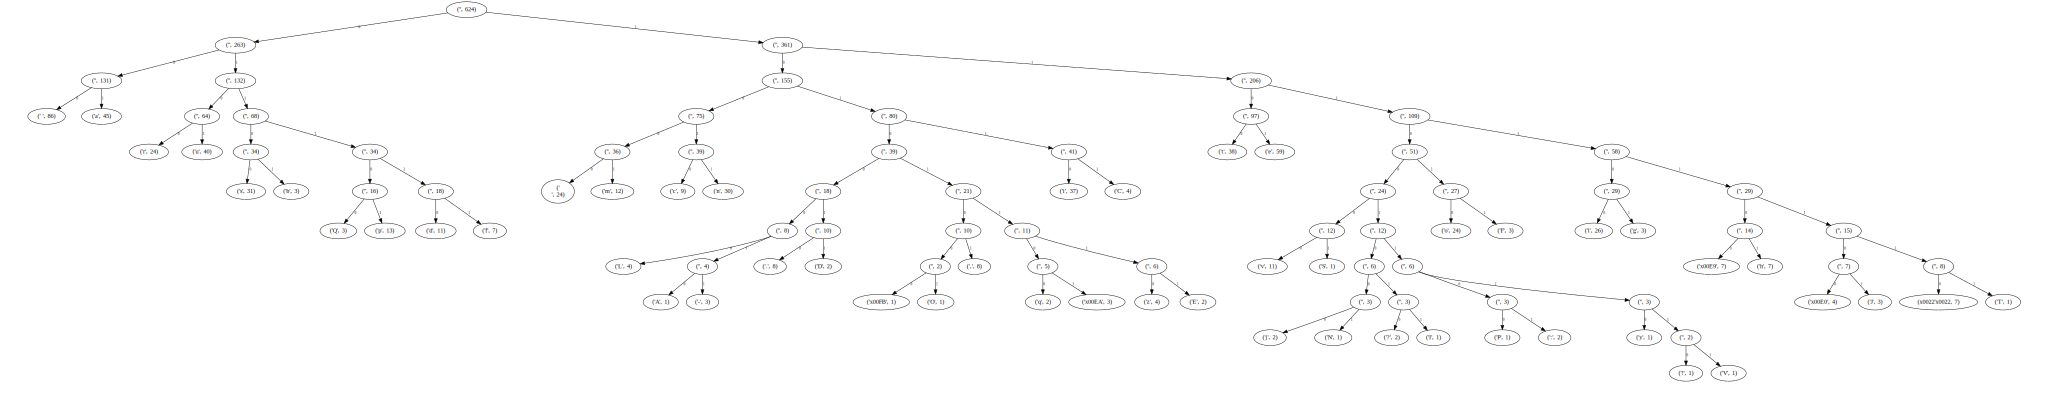

In [366]:
huffman_source = huffman_tree(occ_source)
show_tree(huffman_source)

{'L': 4, 'a': 45, ' ': 86, 'C': 4, 'i': 37, 'g': 3, 'l': 26, 'e': 59, 't': 38, 'F': 3, 'o': 24, 'u': 40, 'r': 24, 'm': 12, '\n': 24, ',': 8, 'y': 1, 'n': 30, 'c': 9, 'h': 7, 'é': 7, 'T': 1, "'": 7, 'S': 1, 'v': 11, 'f': 7, 'd': 11, 'p': 13, 'Q': 3, 'b': 3, 's': 31, ':': 2, 'P': 1, 'D': 2, '.': 8, 'E': 2, 'z': 4, 'ê': 3, 'q': 2, 'J': 3, 'à': 4, '-': 3, 'A': 1, 'O': 1, 'û': 1, 'I': 1, '?': 2, 'N': 1, 'j': 2, 'V': 1, '!': 1}


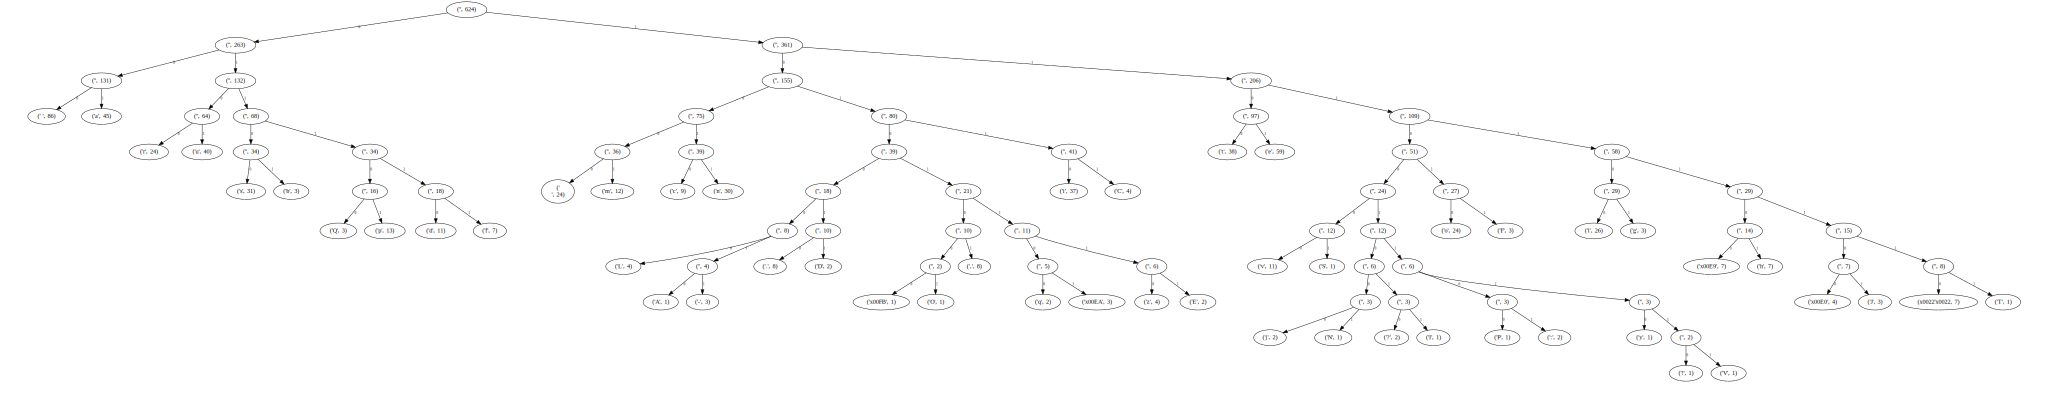

In [378]:
huffman_source2 = huffman_tree(occ_source)
show_tree(huffman_source2)


## Construction de la table de Huffman

Un arbre binaire construit par la méthode de Huffman détermine un codage binaire optimal des symboles de la source. 

Avec l'exemple illustré par la figure ci-dessus nous avons la table de codage ci-dessous dans laquelle figurent à côté de chaque symbole de la source le mot binaire qui lui est associé par le codage :

     symb | code
     -----------
        a | 1
        b | 00
        c | 010
        d | 011


**À faire** Réalisez la fonction suivante qui à partir d'un arbre de Huffman produit la table de codage sous forme d'un dictionnaire.

Appliquez cette fonction à l'exemple du texte source.

In [368]:
def tree_to_coding(tree):
    '''
    :param tree: (BinaryTree) un arbre de Huffman
    :return: (dict) une table de codage
    '''
    dico={}
    if tree.is_leaf():
        return{tree.get_data()[0]:""}
    else:
        for let,code in tree_to_coding(tree.get_left_subtree()).items():
            dico[let]="0"+code
        for let,code in tree_to_coding(tree.get_right_subtree()).items():
            dico[let]="1"+code
        return dico

In [369]:
codage_source = tree_to_coding(huffman_source)
for symb in codage_source:
    print('{:s} : {:s}'.format(symb, codage_source[symb]))

  : 000
a : 001
r : 0100
u : 0101
s : 01100
b : 01101
Q : 011100
p : 011101
d : 011110
f : 011111

 : 10000
m : 10001
c : 10010
n : 10011
L : 1010000
A : 10100010
- : 10100011
. : 1010010
D : 1010011
û : 10101000
O : 10101001
, : 1010101
q : 10101100
ê : 10101101
z : 10101110
E : 10101111
i : 10110
C : 10111
t : 1100
e : 1101
v : 1110000
S : 1110001
j : 111001000
N : 111001001
? : 111001010
I : 111001011
P : 111001100
: : 111001101
y : 111001110
! : 1110011110
V : 1110011111
o : 111010
F : 111011
l : 111100
g : 111101
é : 1111100
h : 1111101
à : 11111100
J : 11111101
' : 11111110
T : 11111111


## Encodage de la source

Disposant de la table de codage optimal de la source, il ne reste qu'à encoder la source avec ce codage.

**À faire** Réalisez la fonction suivante. 

Encodez le texte source.

In [370]:
def encode(source, coding_table):
    '''
    :param source: (str) texte source à encoder
    :param coding_table: (dict) une table de codage
    :return: (str)
    '''
    carac=""
    for let in source:
        carac+=coding_table[let]
    return carac
 

In [371]:
texte_encode = encode(texte_source, codage_source)
texte_encode

'101000000100010111101101111010011111001101000110111000001111000010001110111110100101010010001101101000010000101000000100010111101101111010011111001101101010100000111100111000110011110000010010111110100110011110011111001000011111111111010010111000001111001111111011111001100111110010101011000011100011101000110001001110100101111000000100001111111101001001100000011110111110001110111101001010100111000001011101100000111000101001100110111100001111000010000110110110011001101000011111010111000001110000110110011010111010001110011011000011100110000101100000010110011000011001101010111110000001110111011100101101100000100011110100100100101101001010110000101001111010001000111101001011001011111011101000111010010100001111011010001110000110101001000110110011000110011010010101101001010000101011111111001111001101000001111100111100001000100100100101101101010000001111100110001101101001111011000010111111110111011010111000011110000100011101111101001010100100011011000001100001000111000011101010110011001011010

**À faire**  Calculez le rapport des longueurs du texte encodé et du texte source. Interprétez le résultat obtenu.

In [372]:
taux=len(texte_encode)/len(texte_source)
taux

4.854166666666667

Ce rapport donne le nombre moyen de bits nécessaires à l'encodage des symboles de la source. 
Ici, chaque caractère du texte source est encodé par le codage de Huffman avec en moyenne 4,65 bits. Or le texte source, lorsqu'il est encodé en UTF-8 est encodé avec 8 bits pour chacun des caractères non accentués et 16 bits pour les caractères accentués.

# Décodage 

Quel est le meilleur outil pour décoder un texte encodé avec un codage de Huffman ?

Si la table de codage permet facilement l'opération de codage en associant à chaque symbole de la source un mot binaire, elle n'est pas d'une grande utilité pour le décodage. En effet, pour le décodage il s'agit de déterminer un symbole de la source à partir d'un mot binaire. Mais étant donné que les mots d'un codage optimal n'ont pas tous la même longueur (c'est le but d'un codage optimal), le problème c'est qu'on ne sait pas quel mot il faut tenter de décoder.

Le bon outil pour le décodage est l'arbre de codage. Avec cet arbre, en parcourant la chaîne de bits à décoder on descent à gauche si le bit courant est un 0, ou à droite si c'est un 1. Lorsqu'on arrive sur une feuille, on a décodé un symbole. Il reste à poursuivre le décodage en repartant de la racine de l'arbre de codage.

**À faire** Réalisez la fonction de décodage décrite ci-dessous en suivant la méthode esquissée ci-dessus.

In [388]:
def decode(encoded_source, tree):
    '''
    :param encoded_source: (str) la chaîne binaire à décoder
    :param tree: (BinaryTree) l'arbre de Huffman du codage utilisé
    :return: (str) le message source décodé
    '''
    txt_decode=""
    while len(encoded_source)!=0:
        arbre=tree
        while not arbre.is_leaf():
            if encoded_source[0]=="0":    # test du caractere "0"
                arbre=arbre.get_left_subtree()
                #print(weight(arbre))
                encoded_source=encoded_source[1:]
            else:
                arbre=arbre.get_right_subtree()
                encoded_source=encoded_source[1:]
        txt_decode+=arbre.get_data()[0]
    return txt_decode

In [389]:
print(decode(texte_encode, huffman_source2)) #== texte_source

La Cigale et la Fourmi

La Cigale, ayant chanté
Tout l'été,
Se trouva fort dépourvue
Quand la bise fut venue :
Pas un seul petit morceau
De mouche ou de vermisseau.
Elle alla crier famine
Chez la Fourmi sa voisine,
La priant de lui prêter
Quelque grain pour subsister
Jusqu'à la saison nouvelle.
Je vous paierai, lui dit-elle,
Avant l'Oût, foi d'animal,
Intérêt et principal. 
La Fourmi n'est pas prêteuse :
C'est là son moindre défaut.
Que faisiez-vous au temps chaud ?
Dit-elle à cette emprunteuse.
Nuit et jour à tout venant
Je chantais, ne vous déplaise.
Vous chantiez ? j'en suis fort aise.
Eh bien! dansez maintenant.



# Source dans des fichiers

Dans cette partie, nous allons mettre en œuvre l'algorithme de Huffman en vue de compresser des fichiers. Les sources ne seront donc plus nécessairement des textes (chaînes de caractères) mais des fichiers considérés comme des séquences d'octets indépendamment de la signification de ces octets.

La méthode de compression envisagée consiste à

1. établir le nombre d'occurrences des octets contenus dans le fichier à compresser ;
2. établir un codage de Huffman correspondant aux nombres d'occurrences déterminés au point précédent ;
3. utiliser ce codage pour encoder la séquence d'octets du fichier ;
4. écrire la chaîne binaire obtenue dans un fichier, au format binaire.


## Complétion

Dans un fichier la quantité atomique d'information qu'il est possible de lire ou écrire est l'octet, c'est-à-dire un nombre entier qui s'écrit en binaire sur huit bits. Pour traiter le dernier point listé ci-dessus, il va falloir découper la chaîne de bits issue du point précédent en facteurs de huit bits. Mais que faire si la longueur de la chaîne n'est pas multiple de huit ?

Par exemple, le texte encodé précédemment a une longueur qui n'est pas multiple de 8.

In [ ]:
q, r = divmod(len(texte_encode), 8)
print(q, r)

La chaîne de bits représentant le texte encodé peut donc être découpée en 363 facteurs de huit bits avec un reliquat de trois bits.

In [ ]:
texte_encode[-3:]

Une solution pour pouvoir coder ce reliquat consiste à

* le compléter en ajoutant suffisamment de bits pour en avoir huit
* de façon à pouvoir identifier facilement, lors du décodage, les bits inutiles.

Par exemple, on ajoute au reliquat un mot de la forme `10...0` le nombre de zéros étant choisi de sorte que la longueur du reliquat ajoutée à la longueur de ce mot soit égale à huit.

Avec le reliquat `010` on obtient le mot `O1O1OOOO`.

Au décodage, le dernier mot binaire de longueur huit peut être débarrassé des bits inutiles en repérant le `1` le plus à droite et en éliminant tous les bits à partir de ce `1`.

Pour que cette règle de décodage puisse s'appliquer dans tous les cas, il importe de compléter la chaîne binaire codant une source même si sa longueur est multiple de huit. Dans ce cas on lui ajoute les huit bits inutiles `10000000`.


In [ ]:
def complete(binary_str):
    '''
    :param binary_str: (str) une chaîne de bits
    :return: (str) une chaîne de bits complétée avec un mot de la forme '10...0' de sorte que la chaîne soit de longueur 8
    :CU: len(binary_str) < 8
    :Exemples:
    
    >>> complete('')
    '10000000'
    >>> complete('010')
    '01010000'
    >>> complete('1010111')
    '10101111'
    '''
    return binary_str + '1' + '0' * (7 - len(binary_str))

In [ ]:
[complete(ch) for ch in ('', '010', '1010111')]

In [ ]:
def uncomplete(binary_str):
    '''
    :param binary_str: (str) une chaîne de bits
    :return: (str) une chaîne de bits débarrassée du bit 1 le plus à droite ainsi que des bits qui suivent.
    :CU: binary_str contient au moins un 1.
    :Exemples:
    
    >>> uncomplete('1000000000000000')
    ''
    >>> uncomplete('01010000')
    '010'
    >>> uncomplete('10101111')
    '1010111'
    '''
    return binary_str[:binary_str.rindex('1')]

In [ ]:
[uncomplete(ch) for ch in ('10000000000', '01010000', '10101111')]

## Conversion d'une chaîne de huit bits en entier

La fonction int permet facilement de convertir toute chaîne de bits en l'entier représenté en binaire par cette chaîne. Si on l'applique sur une chaîne de longueur huit, on obtient un octet, c'est-à-dire un nombre entier compris entre 0 et 255 (inclus).

In [ ]:
int('01010000', 2)

## Lecture/écriture d'octets dans un fichier

Nous aurons besoin de lire et écrire des octets dans un fichier. Pour cela le module binary_IO nous sera utile.

In [ ]:
import binary_IO

### Lecture d'octets

In [ ]:
reader = binary_IO.Reader('cigale-UTF-8.txt')
source = reader.get_bytes()
reader.close()
print(source)

### Écriture d'octets

In [ ]:
writer = binary_IO.Writer('copie_cigale.txt')
writer.write_bytes(source)
writer.close()

In [ ]:
%%bash
diff cigale-UTF-8.txt copie_cigale.txt

**Remarque** l'ouverture d'un canal d'écriture vers un fichier existant entraîne une demande de confirmation. Si la confirmation n'est pas donnée, une exception FileExistsError est déclenchée.

In [ ]:
writer = binary_IO.Writer('copie_cigale.txt')
writer.close()

## Sauvegarde et lecture d'un dictionnaire d'occurrences dans un fichier

Afin de pouvoir décoder un fichier il nous faut connaître le codage utilisé pour l'encodage de ce fichier. Or ce codage est entièrement déterminé par le fichier source original que le plus souvent n'avons pas.

Par conséquent, il va être nécessaire de coder l'information permettant de reconstruire le codage. Cette information est par exemple le dictionnaire d'occurrences des octets du fichier d'origine.

In [ ]:
exple_occ = {0: 3, 32 : 10, 65 : 20, 97 : 256}

On peut enregistrer ce dictionnaire dans un fichier au format texte.

In [ ]:
with open('essai_sauv_dico_txt.occ', 'wt') as writer:
    for symb in exple_occ:
        writer.write('{:d}:{:d}\n'.format(symb, exple_occ[symb]))

In [ ]:
%cat essai_sauv_dico_txt.occ

In [ ]:
%ls -l essai_sauv_dico_txt.occ

In [ ]:
def save_occurrencies(occ, filename):
    '''
    :param occ: (dict) un dictionnaire d'occurrences d'octets
    :param filename: (str) nom du fichier de sauvegarde du dictionnaire
    :return: (NoneType)
    :side effect: crée un nouveau fichier nommé filename codant le dictionnaire occ
    :CU: droit d'écriture du fichier
    '''
    with open(filename, 'wt') as writer:
        for symb in occ:
            writer.write('{:d}:{:d}\n'.format(symb, occ[symb]))

In [ ]:
save_occurrencies(exple_occ, 'essai_sauv_dico.occ')

In [ ]:
%ls -l essai_sauv_dico.occ

In [ ]:
%cat essai_sauv_dico.occ

In [ ]:
def read_occurrencies(filename):
    '''
    :param filename: (str) nom du fichier contenant un dictionnaire d'occurrences
    :return: (dict) le dictionnaire d'occurrences lu dans le fichier filename
    :CU: droit de lecture du fichier + conformité du format.
    '''
    occ = dict()
    with open(filename, 'rt') as reader:
        for line in reader:
            elts = line.rstrip().split(':')
            occ[int(elts[0])] = int(elts[1])
    return occ

In [ ]:
read_occurrencies('essai_sauv_dico.occ')

## Encodage d'un fichier

In [ ]:
def source_encoding(in_filename, out_filename):
    '''
    :param in_filename: (str) nom du fichier à encoder
    :param out_filename: (str) nom du fichier à produire
    :return: (NoneType)
    :side effect: produit deux nouveaux fichiers nommés
       * out_filename contenant une version optimalement codée de in_filename
       * out_filename.occ contenant une description des nombres d'occurrences des octets du fichier in_filename
    :CU: droit de lecture de in_filename, droit d'écriture de out_filename + out_filename inexistant
    '''
    # lecture des octets du fichier source
    reader = binary_IO.Reader(in_filename)
    source = reader.get_bytes()
    reader.close()
    # calcul du nbre d'occurrences et construction de la table de codage
    occ_source = sequence_to_occurrences(source)
    huff_tree = huffman_tree(occ_source)
    huff_coding = tree_to_coding(huff_tree)
    # encodage de la source
    encoded_source = encode(source, huff_coding)
    # calcul du nombre d'octets et du reliquat à compléter
    q, r = divmod(len(encoded_source), 8)
    # encodage de la source dans un fichier binaire
    writer = binary_IO.Writer(out_filename)
    writer.write_bytes([int(encoded_source[8*i:8*(i+1)], 2) for i in range(q)])
    writer.write_bytes([int(complete(encoded_source[8*q:]), 2)])
    writer.close()
    # écriture du codage utilisé dans un fichier binaire
    save_occurrencies(occ_source, out_filename + '.occ')

In [ ]:
source_encoding('cigale-UTF-8.txt', 'cigale.huff')

In [ ]:
%ls -l cigale*

**À faire** Traitez d'autres exemples.

## Décodage d'un fichier

In [ ]:
def file_decoding(in_filename, out_filename):
    '''
    :param in_filename: (str) nom du fichier à décoder
    :param out_filename: (str) nom du fichier à produire
    :return: (NoneType)
    :side effect: produit un nouveau fichier nommé
       * out_filename contenant le fichier in_filename décodé selon les nombres d'occurrences
         déterminés par le fichier in_filename.occ 
    :CU: droit de lecture de in_filename, droit d'écriture de out_filename + out_filename inexistant
    '''
    # lecture et constrution du codage
    occ_source = read_occurrencies(in_filename + '.occ')
    # construction de l'arbre de Huffman
    huff_tree = huffman_tree(occ_source)
    # lecture et construction d'une chaîne de bits depuis le fichier à décoder
    reader = binary_IO.Reader(in_filename)
    encoded_source = ''.join('{:08b}'.format(oct) for oct in reader.get_bytes())
    reader.close()
    # élimination de la complétion
    encoded_source = encoded_source[:encoded_source.rindex('1')]
    # décodage
    l_bytes = []
    current_tree = huff_tree
    for bit in encoded_source:
        try:
            current_tree = (current_tree.get_left_subtree() if bit == '0' 
                            else current_tree.get_right_subtree())
        except bt.BinaryTreeError:
            raise AssertionError('arbre de Huffman incorrect')
        if current_tree.is_leaf():
            l_bytes.append(current_tree.get_data()[0])
            current_tree = huff_tree
    if huff_tree != current_tree:
        raise AssertionError('texte encodé incorrect')
    # écriture des octets dans un fichier
    writer = binary_IO.Writer(out_filename)
    writer.write_bytes(l_bytes)
    writer.close()

In [ ]:
file_decoding('cigale.huff', 'cigale.decode')

In [ ]:
%%bash
diff cigale-UTF-8.txt cigale.decode

**À faire** Traitez d'autres exemples.

In [ ]:
source_encoding('origine_especes.txt', 'origine_especes.huff')

In [ ]:
%ls -l origine_especes.*

In [ ]:
file_decoding('origine_especes.huff', 'origine_especes.decode')

In [ ]:
%%bash
diff origine_especes.txt origine_especes.decode